# Projet 3 : Concevez une application au service de la santé publique

### Votre mission

Après avoir lu l’appel à projets, voici les différentes étapes que vous avez identifiées :

1) Traiter le jeu de données afin de repérer des variables pertinentes pour les traitements à venir. Automatiser ces traitements pour éviter de répéter ces opérations. Le programme doit fonctionner si la base de données est légèrement modifiée (ajout d’entrées, par exemple).

2) Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données. Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement. L’appel à projets spécifie que l’analyse doit être simple à comprendre pour un public néophyte. Soyez donc attentif à la lisibilité : taille des textes, choix des couleurs, netteté suffisante, et variez les graphiques (boxplots, histogrammes, diagrammes circulaires, nuages de points…) pour illustrer au mieux votre propos.

3) Confirmer ou infirmer les hypothèses  à l’aide d’une analyse multivariée. Effectuer les tests statistiques appropriés pour vérifier la significativité des résultats.

4) Élaborer une idée d’application. Identifier des arguments justifiant la faisabilité (ou non) de l’application à partir des données Open Food Facts.

5) Rédiger un rapport d’exploration et pitcher votre idée durant la soutenance du projet.

# Import des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Nous chargeons le dictionnaire des dtypes sous-classés.

In [2]:
import json
filename = 'dict_dtypes.json'

# Loading
with open(filename, 'r') as infile:
    dict_dtypes = json.load(infile)

In [3]:
path_file = "en.openfoodfacts.org.products.csv"

# Print the size of the final database
import os
print("The size of the initial database is: {} bytes.".format(os.path.getsize(path_file)))

The size of the initial database is: 2374884505 bytes.


Le fichier initial a une taille d'environ 2,4 Go.

In [4]:
# Loading data
data_raw = pd.read_csv(path_file, # file
                       sep="\t", # separator
                       low_memory=False, # avoid a warning for big files
                       dtype=dict_dtypes, # downcasted dtypes
                      )
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882172 entries, 0 to 882171
Columns: 175 entries, code to carnitine_100g
dtypes: float32(117), int32(2), object(56)
memory usage: 777.4+ MB


Le sous-classement des dtypes nous a permis d'alléger l'allocation mémoire d'environ 35% (774 Mo au lieu de +1.2 Go).

## Sous-classement des dtytes (*downcast*)
Par défaut, Pandas charge les données en int64 ou en float64. Pour limiter la charge mémoire, il est possible d'essayer de changer le type de données.

In [5]:
def downcast_dtypes(dataframe, save=True):
    '''This function tries to downcast integer and floating dtypes columns
    to the smallest numerical corresponding dtype.
    It returns a dictionnary of the actually downcasted dtypes.'''
    
    # initialise the dict of downcasted dtypes for features
    dict_dtypes = {}
    
    # getting list of integer columns
    columns_int = dataframe.select_dtypes(include=['integer']).columns
    
    for column in columns_int:
        old_dtype = str(dataframe[column].dtypes)
        # trying to downcast integer columns (min.: np.int8)
        dataframe[column] = pd.to_numeric(dataframe[column], downcast='integer')
        new_dtype = str(dataframe[column].dtypes)
        
        # if dtype was downcasted
        if new_dtype != old_dtype:
            # add new key in dictionnary
            dict_dtypes[column] = str(dataframe[column].dtypes)

    # getting list of floatting columns
    columns_float = dataframe.select_dtypes(include=['floating']).columns
    
    for column in columns_float:
        old_dtype = str(dataframe[column].dtypes)
        # trying to downcast float columns (min.: np.float32)
        dataframe[column] = pd.to_numeric(dataframe[column], downcast='float')
        new_dtype = str(dataframe[column].dtypes)
        
        # if dtype was downcasted
        if new_dtype != old_dtype:
            # add new key in dictionnary
            dict_dtypes[column] = str(dataframe[column].dtypes)
        
        
    # Saving as a json file
    if save==True:
        import json
        
        filename = 'dict_dtypes.json'
        with open(filename, 'w') as outfile:
            json.dump(dict_dtypes, outfile)
        
    # return dict of downcasted dtypes
    return dict_dtypes

DataFrame has 882172 rows and 175 columns.
The global filling rate of the DataFrame is : 20.99%


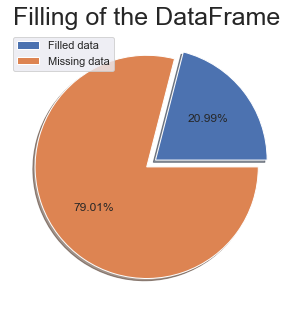

In [6]:
def filling_rate(dataframe):
    """Calcuates and displays the shape of the dataframe and the filling rate"""
    
    # Loading libraries
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math
    
    sns.set()
    
    # get the numbers of rows and columns in the dataframe
    nb_rows, nb_columns = dataframe.shape
    print("DataFrame has {} rows and {} columns.".format(nb_rows,nb_columns))

    # get the number of non-Nan data in the dataframe
    nb_data = dataframe.count().sum()

    # computing the filling rate
    filling_rate = nb_data / (nb_rows * nb_columns)
    print("The global filling rate of the DataFrame is : {:.2%}".format(filling_rate))
      
    # Setting frequencies and labels for pie plot
    frequencies = [filling_rate, 1 - filling_rate]
    labels = ["Filled data", "Missing data"]
    
    # General informations for the pie plot
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title("Filling of the DataFrame", fontsize=25)
    ax.axis("equal")
    explode = (0.1, 0)  # only "explode" the 1st slice

    # Plotting pie plot
    ax.pie(frequencies,
           explode=explode,
           # labels=labels,
           autopct='%1.2f%%',
           shadow=True,
          )
    plt.legend(labels)

filling_rate(data_raw)

In [7]:
data_raw.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000000010,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1550246813,2019-02-15T16:06:53Z,1550246813,2019-02-15T16:06:53Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000000000000010,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1550246831,2019-02-15T16:07:11Z,1550246831,2019-02-15T16:07:11Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1529059204,2018-06-15T10:40:04Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Chaque colonne correspond à une feature, et chaque ligne correspond à un produit.

Nous voyons que sur les premières lignes au moins, de nombreuses données sont manquantes. Ces données manquantes sont indiquées par NaN.

# Sélection des colonnes

In [8]:
# List of names of the columns
print("Names of the columns :", list(data_raw))

Names of the columns : ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_f

Comme indiqué dans l'appel à projet, les champs sont séparés en sections. Mais selon le descriptif des données sur le site  [openfoodfacts.org](https://world.openfoodfacts.org/data/data-fields.txt), il y a 5 sections et non pas 4. Nous remarquons aussi certaines variations dans les intitulés des colonnes, et quelques colonnes supplémentaires.

1. "*general informations*" : les informations générales sur la fiche du produit
   * de la colonne 'code'…
   * … à la colonne 'quantity'
2. "*tags*" : un ensemble de tags
   * de la colonne 'packaging'…
   * … à la colonne 'countries_en'
3. "*ingredients*": les ingrédients et additifs éventuels.
   * de la colonne 'ingredients_text'…
   * … à la colonne 'traces_en'
4. "*misc. data*" : des informations diverses
   * de la colonne 'serving_size'…
   * … à la colonne 'image_nutrition_small_url'
5. "*nutrition facts*" : des informations nutritionnelles
   * de la colonne 'energy_100g'…
   * … à la colonne 'carnitine_100g'



# Transtypage des données

### Variables temporelles

In [9]:
# List of date and time features
datetime_features = [
    'created_datetime',
    'last_modified_datetime',
    'created_t',
    'last_modified_t',
]

# Converting the date and time features
for feature in datetime_features:
    data_raw[feature] = pd.to_datetime(data_raw[feature])

### Variables catégorielles nominales

In [10]:
# List of nominal features
nominal_features = [
    'categories',
    'categories_tags',
    'categories_en',
]

# Converting the dtype for nominal features
for feature in nominal_features:
    data_raw[feature] = data_raw[feature].astype('category')

### Variables catégorielles ordinales

In [11]:
# List of ordinal features
ordinal_features = [
    'nova_group',
    'nutrition_grade_fr',
]

# Converting the dtype of ordinal features
from pandas.api.types import CategoricalDtype

for feature in ordinal_features:
    data_raw[feature] = data_raw[feature].astype(CategoricalDtype(ordered=True))

In [12]:
def piechart_dtypes(dataframe):
    """Plot a piechart of dtypes of features in the dataframe"""
    
    # Loading libraries
    import matplotlib.pyplot as plt
    
    # get the list of the dtypes in the dataframe
    dtypes_count = dataframe.get_dtype_counts() 
    # Should use : dtypes_count = dataframe.dtypes.value_counts()
    # Fix : dtypes_count = df.dtypes.astype(str).value_counts()

    # Set frequencies and labels
    labels = dtypes_count.index.values
    frequencies = dtypes_count.values

    # General informations for the pie plot
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title("Types of features", fontsize=25)
    ax.axis("equal")

    # Plotting pie plot
    ax.pie(frequencies,
            # labels=labels,
            autopct='%1.2f%%',
            shadow=True,
              )
    plt.legend(labels)

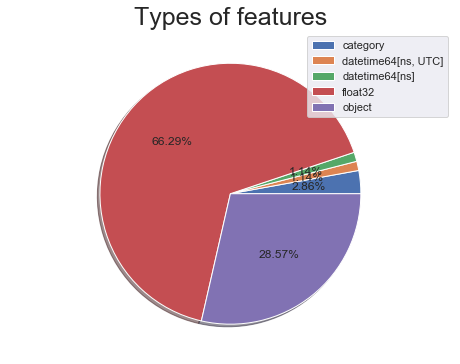

In [13]:
dataframe = data_raw
piechart_dtypes(data_raw)

## Élimination des colonnes non-pertinentes pour le projet

In [14]:
# List of columns to drop
columns_useless = [
    'url',
    'creator',
    'image_url',
    'image_small_url',
    'image_ingredients_url',
    'image_ingredients_small_url',
    'image_nutrition_url',
    'image_nutrition_small_url',
    
    'created_datetime',
    'last_modified_datetime',
    'created_t',
    'last_modified_t',
    
    'states',
    'states_tags',
    'states_en',
]

# Droping useless columns
data_cleaned = data_raw.drop(columns=columns_useless)

# Gestion des doublons (code-barres) : fusion
Nous allons nettoyer les doublons (code-barres identiques).

In [15]:
def number_duplicates(dataframe, subset):
    """This function displays and return the number of duplicate in a dataset,
    based on a subset of columns."""
    
    # Marking all duplicates
    duplicates = dataframe.duplicated(subset=subset, keep=False)
    
    # If there are duplicated rows
    if True in list(duplicates.unique()):
        
        # Display and return number of duplicated rows
        result = len(dataframe[duplicates])
        print("There are {} duplicated rows.".format(result))
        return result
    
    # If there are no duplicated rows
    else:
        print("There are no duplicated rows.")
        return 0

In [16]:
dataframe = data_cleaned
subset = ["code"]

number_duplicates(dataframe, subset)

There are 310 duplicated rows.


310

Nous définissons une fonction pour gérer les doublons.

In [17]:
def duplicates_merging(dataframe,subset):
    """This function handles duplicates rows in the dataframe, based on a subset of columns (features)."""

    # Checking if there are some duplicated rows
    duplicates_mask = dataframe.duplicated(subset=subset, keep=False)
    if True not in list(duplicates_mask.unique()):
        print("No duplicates.")
        return dataframe
    
    print("Number of duplicates rows :", len(dataframe[duplicates_mask]))
    
    # Filtering the dataframe to keep only duplicated rows
    duplicates_mask = dataframe.duplicated(subset=subset, keep=False)
    duplicates_df = dataframe[duplicates_mask]

    # Group-by subset of columns used for key, sort=False to speed-up
    gb = duplicates_df.groupby(subset, sort=False)

    # Initializing aggregated dataframe
    agg_df = pd.DataFrame()

    # Identification of numerical and non-numerical columns
    numeric_columns = list(dataframe.select_dtypes(include=[np.number]).columns.values)

    # defining aggregation function for non-numerical columns
    def agg_mode(x): m = pd.Series.mode(x); return m.values[0] if not m.empty else np.nan

    # Iterating upon columns
    for column in dataframe.columns:

        # Calculate the mean of each group for numeric columns
        if column in numeric_columns:
            agg_col = gb[column].agg('mean')

        # Calculate the mode of each group for numeric columns
        else:
            agg_col = gb[column].agg(agg_mode)
            
        # adding the aggregated column to aggregated dataframe
        agg_df = pd.concat([agg_df, agg_col], axis=1, sort=True)

    # Dropping all duplicates
    dataframe_cleaned = dataframe.drop_duplicates(subset=subset, keep=False)

    # Concatenating the dataframe without duplicates and the aggregated rows for duplicates
    result = dataframe_cleaned.append(agg_df, ignore_index=True, sort=False)

    print("Shape after handling duplicates :", result.shape)
    return result

In [18]:
dataframe = data_cleaned
subset = ['code']

data_cleaned = duplicates_merging(dataframe,subset)

Number of duplicates rows : 310
Shape after handling duplicates : (882017, 160)


# Calcul du taux de remplissage par feature

In [19]:
nb_rows, nb_columns = data_cleaned.shape

# Count of the values on each column
columns_count = data_cleaned.count()

# Sort the Series
columns_count = columns_count.sort_values(ascending=False)

# Calculating filling rates
filling_rates = columns_count / nb_rows

# Display a sampling (1 out of 10) of columns names and filling rates
filling_rates[::10]

code                                1.000000
carbohydrates_100g                  0.787268
ingredients_text                    0.485637
serving_quantity                    0.294499
calcium_100g                        0.164397
generic_name                        0.101254
origins_tags                        0.057202
vitamin-b2_100g                     0.013173
cocoa_100g                          0.004868
vitamin-k_100g                      0.001134
collagen-meat-protein-ratio_100g    0.000325
silica_100g                         0.000112
inositol_100g                       0.000040
-lauric-acid_100g                   0.000007
-montanic-acid_100g                 0.000001
-caproic-acid_100g                  0.000000
dtype: float64

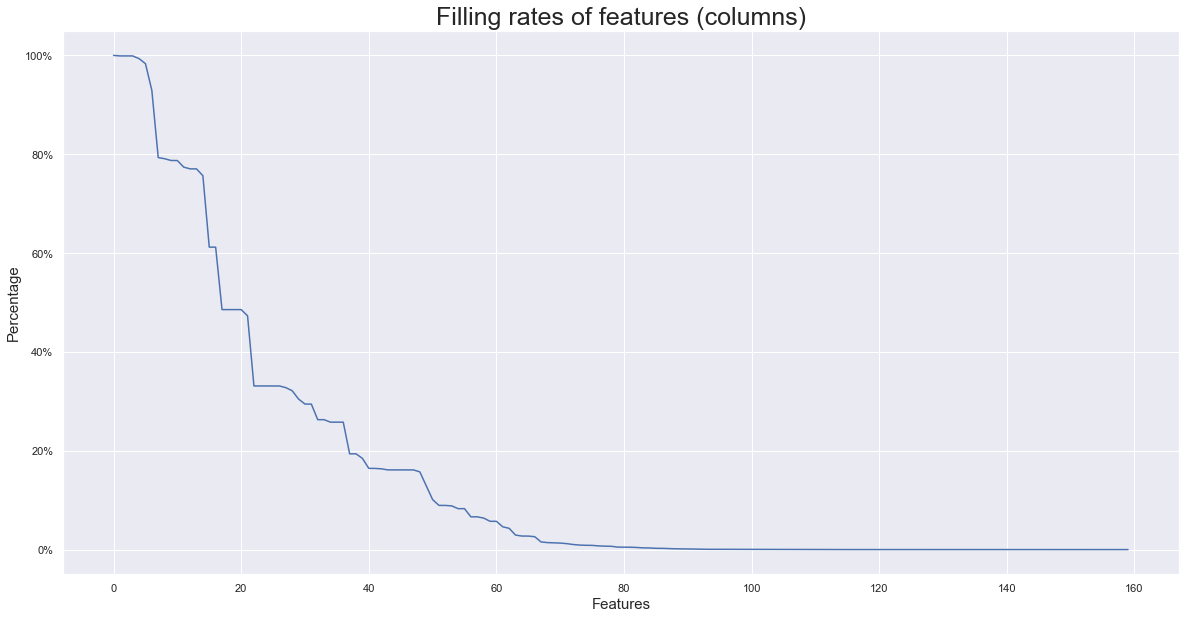

In [20]:
# Plot chart of the filling_rates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()

x = range(nb_columns)
y = filling_rates

fig, ax = plt.subplots(figsize=(20, 10))
plt.title("Filling rates of features (columns)", fontsize=25)
plt.xlabel("Features", fontsize=15)
plt.ylabel("Percentage", fontsize=15)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plot = ax.plot(x, y)

Nous constatons que quelques colonnes sont intégralement remplis.

Nous constatons aussi que de nombreuses colonnes sont très faiblement ou pas du tout remplies. Ainsi, environ une centaine d'indicateurs (sur les 175 que contient la table) ont un remplissage inférieur à 5%.

## Imputation pour les lignes ayant un nom de produit identique
Pour ces lignes qui possèdent le même nom de produit, nous n'allons pas "supprimer ni fusionner les doublons" mais utiliser le champ 'product_name' comme clé pour faire de l'imputation.

In [21]:
dataframe = data_cleaned
subset = ["product_name"]

number_duplicates(dataframe, subset)

There are 370638 duplicated rows.


370638

In [22]:
def imputation(dataframe, feature, keys):
    """This function impute substitute values for missing values for a specific column (feature),
    based on other rows sharing some properties (values on other fields of subset).
    Also add a new feature to inform if the value was imputed.
    Does only handle numeric features yet."""
    
    # Identify NaN values pre-imputation
    mask_before = dataframe[feature].isnull()
    
    # Copying the dataframe to avoid manipulating a slice
    result = dataframe.copy()
    
    # Initialize column for imputed values if doesn't exist
    if "imputed_" + feature not in result.columns:
        result["imputed_" + feature] = False
    
    # Iterating on each feature in the subset
    for column in keys:
        
        # Grouping the DataFrame on the column's value, sort=False to speed-up
        grouped = dataframe.groupby(column, sort=False)
        
        # Computing the mean of feature for each group
        means_of_group = grouped[feature].transform('mean') # to adapt for object and categorical dtypes features
        
        # Filling missing values with the mean of each group
        result[feature].fillna(value=means_of_group, axis=0, inplace=True)
    
    # Identify NaN values post-imputation
    mask_after = result[feature].isnull()
    
    # Values imputed : boolean symetric difference
    mask_imputed = mask_after ^ mask_before
    
    # Update the column to inform that the feature was imputed
    result["imputed_" + feature][mask_imputed] = True # raise a SettingWithCopyWarning
    
    return result

DataFrame has 882017 rows and 160 columns.
The global filling rate of the DataFrame is : 15.40%


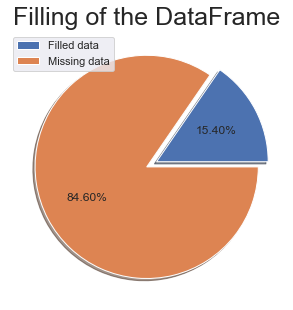

In [23]:
dataframe = data_cleaned

# Before imputation
filling_rate(dataframe)

In [24]:
# Ordered list of the keys used to impute the feature
keys = ['product_name']

# Selection of numeric columns with high enough filling rate
numeric_columns = data_cleaned.select_dtypes(include=['number']).columns

# Selection of columns to apply
mask = filling_rates > 0.75
filled_columns = list(filling_rates[mask].index)

# Intersection of the two sets (numeric and filling rate)
columns_to_impute = list(set(numeric_columns) & set(filled_columns))

# Features to impute : numerical columns (barcode is an object column)
for feature in columns_to_impute:
    
    # Proceed to imputation
    data_cleaned = imputation(dataframe, feature, keys)

C:\Users\Lebrun\Anaconda3\envs\DS_projet3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


DataFrame has 882017 rows and 161 columns.
The global filling rate of the DataFrame is : 15.95%


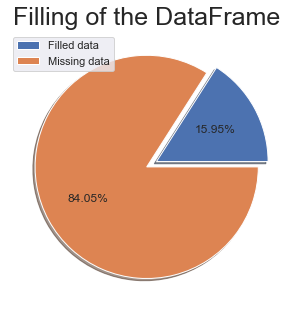

In [25]:
dataframe = data_cleaned

# After imputation
filling_rate(dataframe)

Remarque : le taux de remplissage a baissé par rapport au taux de remplissage initial en raison de l'élimination des colonnes non pertinentes pour le projet.

##  Imputation des valeurs numériques manquantes


Nous sélectionnons les colonnes numériques ayant un taux de remplissage suffisant (> 75 %).

### Identification des colonnes remplies à plus de 75%


In [27]:
mask = filling_rates > 0.75
filling_rates[mask]

code                  1.000000
countries_en          0.998958
countries_tags        0.998958
countries             0.998958
pnns_groups_2         0.993442
pnns_groups_1         0.983347
product_name          0.929310
energy_100g           0.793303
proteins_100g         0.790943
fat_100g              0.787405
carbohydrates_100g    0.787268
sugars_100g           0.773920
salt_100g             0.770428
sodium_100g           0.770398
saturated-fat_100g    0.756524
dtype: float64

Les champs remplis à 100% correspondent vraissemblablement à des champs obligatoires (sur le formulaire de remplissage, ou pour l'enregistrement dans la base de données) ou à de données générées automatiquement (timestamps par exemple) lors de l'ajout d'un produit dans la base de données.

### Imputation pour les colonnes remplies à plus de 75%
Nous appliquons l'[imputateur multivarié expérimental](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) de scikit-learn.

In [28]:
# Load libraries
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Selection of numeric columns with high enough filling rate
numeric_columns = data_cleaned.select_dtypes(include=['number']).columns

# Selection of columns to apply
filled_columns = list(filling_rates[mask].index)

# Intersection of the two sets (numeric and filling rate)
columns_to_impute = list(set(numeric_columns) & set(filled_columns))

# Create iterative imputer
imp = IterativeImputer(max_iter=10, random_state=0)

# Train and apply (inplace) the iterative imputer
data_cleaned[columns_to_impute] = imp.fit_transform(data_cleaned[columns_to_impute])

# Nettoyage des lignes

## Filtrage sur le code-barres EAN-13 (colonne 'code')
La documentation du site  [openfoodfacts.org](https://world.openfoodfacts.org/data/data-fields.txt) précise : "*code : barcode of the product (can be EAN-13 or internal codes for some food stores), for products without a barcode, Open Food Facts assigns a number starting with the 200 reserved prefix*".

Nous n'allons toutefois, en raison de notre application, ne garder que les lignes avec un code-barres EAN-13 valide.

In [29]:
def check_key(barcode):
    """This function check the control key (last digit) of the 13-digits barcode."""
    
    # Import of regular expressions module
    import re

    # Definition of regular expression : 13 digits only
    regex = "^\d{13}$"

    # Compilation of regular expression
    pattern = re.compile(regex)
    
    # Return False if the code does not fit regular expression
    if pattern.match(str(barcode))==None:
        return False
    
    # conversion to string to iterate on digits
    barcode_str = str(barcode)
    
    # getting the last digit
    last_digit = int(barcode_str[-1:])
    
    # removing last digit from barcode
    barcode_str = barcode_str[:-1]
    
    # initialisation of the control sum
    sum = 0  
    
    # for each digit in the barcode
    for index, digit in enumerate(barcode_str):
        digit = int(digit) # conversion back as integer
        
        # if index is an even number (digits of rank 1, 3, 5…)
        if index % 2 == 0:
            # adding to the sum with a ponderation of 1
            sum += 1*digit
        
        # if index is an odd number (digits of rank 2, 4, 6…)
        else :
            # adding to the sum with a ponderation of 1
            sum += 3*digit
    
    # computing the control key with division of the key by 10
    rest = sum % 10
    if rest == 0 :
        key = 0
    else:
        key = 10 - rest
    
    # compare control key and last digit of the barcode
    if key == last_digit:
        return True
    else:
        return False

In [30]:
# Matching the pattern in the column 'code' on each line of the DataFrame
mask = [check_key(code) for code in data_cleaned['code']]

# Dropping the rows with non-compliant EAN-13 code
data_cleaned = data_cleaned[mask]
print("Number of rows in the cleaned data:", data_cleaned.shape[0])

Number of rows in the cleaned data: 807754


Le filtrage a permis de nettoyer environ 75'000 lignes.

## Suppression des lignes où le nom est manquant
Pour notre application, le nom est une donnée cruciale. Nous décidons donc de supprimer les lignes pour lesquelles le nom est manquant.

In [31]:
# Droping rows with empty values in a subset of columns
data_cleaned = data_cleaned.dropna(subset=['product_name'])
print("Shape of the cleaned data:", data_cleaned.shape)

Shape of the cleaned data: (767068, 161)


Ce filtrage sur le nom nous a permis d'éliminer 40'000 lignes.

Nous allons maintenant gérer les produits ayant un nom dupliqué.

## Élimination des colonnes remplies à moins de x%
Nous faisons une fonction pour éliminer les variables (colonnes) dont le taux de remplissage est inférieur à un seuil.

In [32]:
def fillingrate_filter_columns(dataframe, limit_rate):
    """This function drop the colums where the filling rate is less than a defined limit rate."""

    # Count of the values on each column
    columns_count = dataframe.count()

    # Number of rows in the dataframe
    nb_rows = dataframe.shape[0]
    
    # Calculating filling rates
    filling_rates = columns_count / nb_rows

    # Define a mask of features with a filling_rate bigger than the limit rate
    mask = filling_rates > limit_rate
    
    # Apply the mask to the filling_rates Series
    filling_rates_selection = filling_rates[mask]
    
    # Get the list of the name of the selected columns
    features_selection = list(filling_rates_selection.index)
    print("Number of columns with a filling rate bigger than  {:.2%} : {} columns.".format(limit_rate, len(features_selection)))

    # Return a projection on the selection of features
    return dataframe[features_selection]

In [33]:
data_cleaned = fillingrate_filter_columns(data_raw, 0.10)

Number of columns with a filling rate bigger than  10.00% : 66 columns.


# Étude du remplissage des lignes
Nous allons maintenant étudier le remplissage par produit (ligne), en vue d'éliminer les lignes trop peu renseignées.

In [34]:
def rows_fillingrate_histogram(dataframe):
    """This function plots an histogram of the distribution of the 
    filling rate for the rows of a dataframe."""

    # Import libraries
    import matplotlib.ticker as ticker

    # Count the non-null values on each row
    row_count = dataframe.count(axis=1)

    # Calculating filling rates
    nb_columns = dataframe.shape[1]
    filling_rates_row = row_count / nb_columns

    # Plotting histogramm
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.title("Rows' filling rate distribution", fontsize=25)
    plt.xlabel("Filling rate", fontsize=15)
    plt.ylabel("Frequency", fontsize=15)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    bins = np.linspace(0, 1, num=51)
    ax.hist(filling_rates_row, bins=bins)
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))
    plt.show()

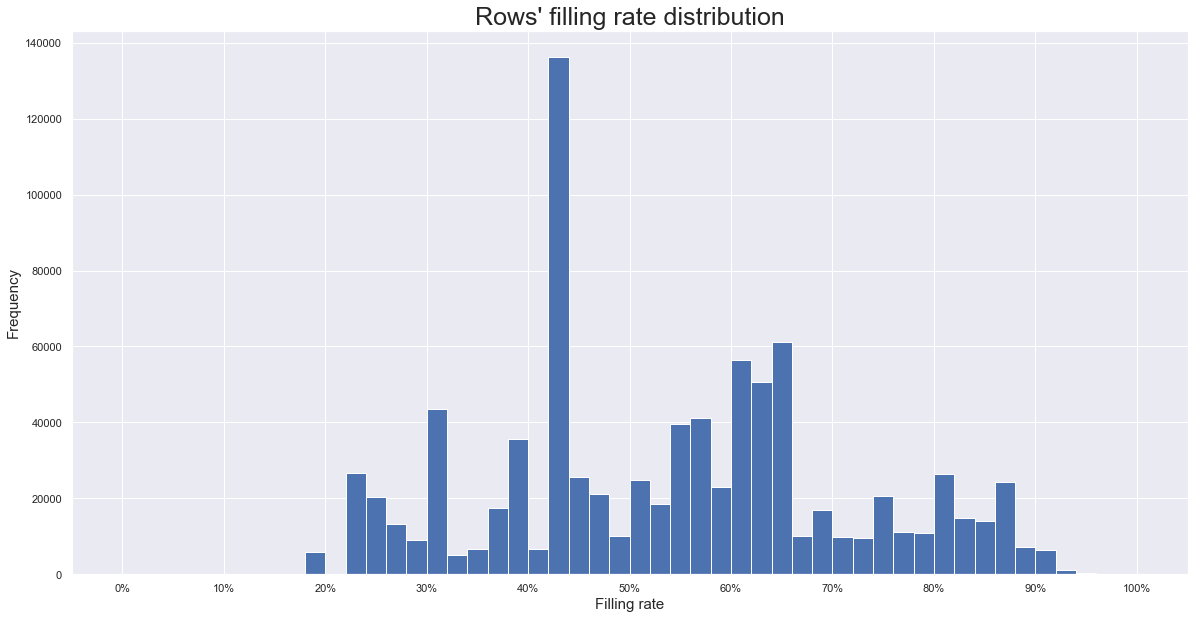

In [35]:
dataframe = data_cleaned
rows_fillingrate_histogram(dataframe)

Nous constatons que les produits (lignes) restant après les nettoyages préliminaires sont au minimum remplis à 20%, et au maximum à 90%.

Nous pouvons néanmoins refaire cette même étude en faisant abstraction des 8 colonnes "obligatoires" (avec un taux de 100%) et de la colonne de 'product_name' que nous avons rendus obligatoire.

## Élimination des lignes remplies à moins de x%

In [36]:
def fillingrate_filter_rows(dataframe, limit_rate):
    """This function drop the colums where the filling rate is less than a defined limit rate."""

    # Count of the values on each rows (pd.Series)
    row_count = dataframe.count(axis=1)

    # Number of columns in the dataframe
    nb_columns = dataframe.shape[1]
    
    # Calculating filling rates for each row
    filling_rates = row_count / nb_columns

    # Define a mask of rows with a filling_rate bigger than the limit rate
    mask = filling_rates > limit_rate
    
    # Displaying result of filtering
    print("Number of rows with a filling rate bigger than  {:.2%}: {} rows.".format(limit_rate, len(dataframe[mask])))

    # Return a projection on the selection of rows
    return dataframe[mask]

In [37]:
data_cleaned = fillingrate_filter_rows(data_cleaned, 0.40)

Number of rows with a filling rate bigger than  40.00%: 698546 rows.


DataFrame has 698546 rows and 66 columns.
The global filling rate of the DataFrame is : 60.05%


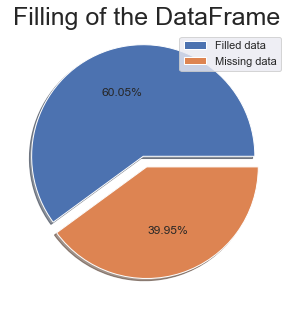

In [38]:
filling_rate(data_cleaned)

# Sauvegarde du pd.DataFrame (méthode *feather*)

In [39]:
# feather does not support serializing a non-default index
data_cleaned = data_cleaned.reset_index()

# Drop the column with original index
data_cleaned = data_cleaned.drop(columns=["index"])

# Save binary file
data_cleaned.to_feather("p3_data.ft")